<a href="https://colab.research.google.com/github/kaiu85/stable-diffusion-workshop/blob/main/Cool_Applications/image_2_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image2Image Pipeline for Stable Diffusion using 🧨 Diffusers 

This notebook shows how to create a custom `diffusers` pipeline for  text-guided image-to-image generation with Stable Diffusion model using  🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers).

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/kaiu85/stable-diffusion-workshop/blob/main/stable_diffusion.ipynb).



First, let us check again, if our instance is using a (GPU) graphics card to accelerate our computations. If yes, then !nvidia-smi should print out some informations, such as GPU type (likely Tesla T4), GPU memory (around 15GB), ... 
If this command fails, you can change the runtime settings via "Runtime -> Change runtime type" (German: "Laufzeit -> Laufzeittyp ändern") and select "GPU".

In [ ]:
!nvidia-smi

Now let us install the fantastic diffusers library and some other required libraries again.

In [ ]:
!pip install diffusers==0.3.0 transformers ftfy
!pip install -qq "ipywidgets>=7,<8"

You need to accept the model license before downloading or using the weights. In this post we'll use model version `v1-4`, so you'll need to  visit [its card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree. 

You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).

Remember, you can create and find your Huggingface tokens 
at https://huggingface.co/settings/tokens.
Alternatively, you can log into your Huggingface.co account,
click on your profile picture on the upper right
and then navigating to "Settings -> Access Tokens".

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Image2Image pipeline.

In [ ]:
import inspect
import warnings
from typing import List, Optional, Union

import torch
from torch import autocast
from tqdm.auto import tqdm

from diffusers import StableDiffusionImg2ImgPipeline

Load the pipeline

In [ ]:
device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
)
pipe = pipe.to(device)

We first download an initial image from the web to our local instance.

In [ ]:
!wget https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg

Feel free to upload your own images. You can open a file explorer by clicking the folder icon on the left.

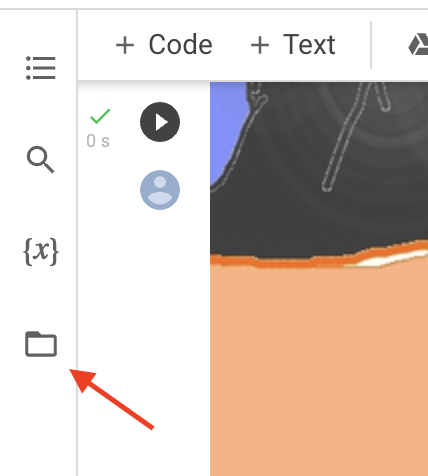

Now you can use the upload icon (red arrow) to upload files from your local computer: 

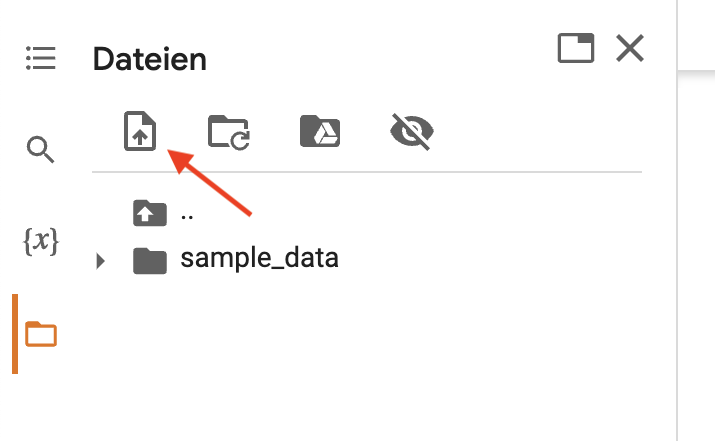

Feel free to upload your own files and change the value of the variable ``filename`` in the next code cell accordingly.

Now we preprocess the local image, so that it fits the format required by the diffusion model.

In [ ]:
import requests
from io import BytesIO
from PIL import Image

filename = 'sketch-mountains-input.jpg'

init_img = Image.open(filename).convert("RGB")
init_img = init_img.resize((768, 512))
init_img

Now we can define a prompt and run the pipeline to transform our input image according to the prompt.

In [ ]:
prompt = "Photograph of a fantasy landscape, highest quality, DSLR."

In the following cell, `strength` is a value between 0.0 and 1.0. This value controls the amount of noise that is added to the input image. Values that approach 1.0 allow for lots of variations but will also produce images that are not semantically consistent with the input.

In [ ]:
generator = torch.Generator(device=device).manual_seed(1024)
with autocast("cuda"):
    image = pipe(prompt=prompt, init_image=init_img, strength=0.99, guidance_scale=7.5, generator=generator).images[0]

In [ ]:
image

In [ ]:
with autocast("cuda"):
    image = pipe(prompt=prompt, init_image=init_img, strength=0.5, guidance_scale=7.5, generator=generator).images[0]

In [ ]:
image

As you can see, when using a lower value for `strength`, the generated image is more closer to the original `init_image`


Now using a different scheduler, namely [LMSDiscreteScheduler](https://huggingface.co/docs/diffusers/api/schedulers#diffusers.LMSDiscreteScheduler). Remember that **schedulers** use the noise, which is predicted from the trained U-Net model to iteratively reconstruct a less noisy version of an image.

In [ ]:
from diffusers import LMSDiscreteScheduler

lms = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear")
pipe.scheduler = lms

In [ ]:
generator = torch.Generator(device=device).manual_seed(1024)
with autocast("cuda"):
    image = pipe(prompt=prompt, init_image=init_img, strength=0.95, guidance_scale=7.5, generator=generator).images[0]

In [ ]:
image

# Interactive Demo

Now we will install "gradio", which is a library, that allows to create nice graphical user interfaces directly within jupyter notebooks. We will use this library to streamline the process of image upload and image-2-image translation, just to make experimentation a bit easier.

In [ ]:
!pip install -q gradio
import gradio as gr

The user interface requires a function, which it can call to start the denoising process, thus we define the ``predict`` function in the next cell.

In [ ]:
def predict(image, prompt, strength, guidance_scale):
  init_img =  image.convert("RGB").resize((512, 512))
  with autocast("cuda"):
    images = pipe(prompt=prompt, init_image=init_img, strength=strength, guidance_scale=guidance_scale).images
  return(images[0])

The next cell defines the user interface. It specifies a title, a way to generate an input image, and boxes to enter the relevant parameters.
**Note**: You can either use ``gr.Paint...`` which lets you draw an input image by hand, or you can use ``gr.ImagePaint``, which lets you upload an image and optionally paint on it.
Then we launch the interface.

In [ ]:
gr.Interface(
    predict,
    title = 'Stable Diffusion Image-2-Image',
    inputs=[
        gr.Paint(type = 'pil', shape = (512, 512)), # USE THIS LINE TO DRAW ON AN EMPTY CANVAS
        #gr.ImagePaint(type = 'pil'), # USE THIS LINE to first UPLOAD and IMAGE and then (optionally) draw on it
        gr.Textbox(label = 'prompt', value = ''),
        gr.Number(label = 'noise strength', value = 0.75),
        gr.Number(label = 'guidance scale', value = 7.5)
    ],
    outputs = [
        gr.Image()
        ]
).launch(debug=True)

# Assignment

Again, please take your time to **play with the model**. Try different input images, parameters (``noise_strength``, ``guidance_scale``) and experiment with many different prompts.

**Please** collect suprisingly good, suprisingly bad, funny and interesting results [here](https://docs.google.com/presentation/d/1n5P9JIyYoISbRIfRgXvwmXFdETlPm1FQ_S7WuqKgqBo/edit?usp=sharing). Feel free to also add links, thoughts and comments, which you want to share with the group.